# FINAL RESULTS

## Libraries import

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# error
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## Functions definition

In [2]:
# Read csv
def read_csv(path):
    return pd.read_csv(path)

In [3]:
# Drop columns
def drop_columns(df,columns):
    return df.drop(columns, 1) 

In [10]:
# Change date format
def date_format(column,date_format):
    return pd.to_datetime(column,format=date_format)

In [13]:
# Join data
def join_data(df_left,df_right,link_fields,link_type):
    return pd.merge(df_left,df_right,on=link_fields,how=link_type)

In [14]:
# Feature engineering

def craft_features(df,calendar_features=True,laglead_calendar_features=True,laglead_temperature=True,
                  roll_temperature=True,daily_temp_features=True):
    # Calendar features
    if calendar_features:
        df["Week_day"]=df.Time.dt.day_name().astype('category').cat.codes
        df['Week_day_category']=np.where(df["Time"].dt.dayofweek>4,'Weekend','Week')
        df['Week_day_category']=df['Week_day_category'].astype('category').cat.codes
        df["Bank_Holiday_Weight"]=df["Country_Bank_Holiday"]+df["Partial_Bank_Holiday_Weight"]

        # Laglead calendar features
        if laglead_calendar_features:
            df["Bank_Holiday_Weight_p24"]=df["Bank_Holiday_Weight"].shift(24)
            df["Bank_Holiday_Weight_n24"]=df["Bank_Holiday_Weight"].shift(-24)
            df["Bank_Holiday_Weight_p168"]=df["Bank_Holiday_Weight"].shift(168)
            df["Week_day_category_p24"]=df["Week_day_category"].shift(24)
            df["Week_day_category_n24"]=df["Week_day_category"].shift(-24)

    # Laglead Temperature 
    if laglead_temperature:
            df["Temp_K_p1"]=df["Temp_K"].shift(1)     
            df["Temp_K_p2"]=df["Temp_K"].shift(2)  

            df["Temp_K_n1"]=df["Temp_K"].shift(-1)     
            df["Temp_K_n2"]=df["Temp_K"].shift(-2)  

            df["Temp_K_p24"]=df["Temp_K"].shift(24)       
            df["Temp_K_p48"]=df["Temp_K"].shift(48)        
            df["Temp_K_p72"]=df["Temp_K"].shift(72)               
            df["Temp_K_p96"]=df["Temp_K"].shift(96)
            df["Temp_K_p120"]=df["Temp_K"].shift(120)
            df["Temp_K_p144"]=df["Temp_K"].shift(144)
            df["Temp_K_p168"]=df["Temp_K"].shift(168)

    # Rolling Statistical values
    if roll_temperature:
        df['Temp_K_SMA3']=df['Temp_K'].rolling(3,center=True).mean()
        df['Temp_K_SMA5']=df['Temp_K'].rolling(5,center=True).mean()
        df['Temp_K_SMA12']=df['Temp_K'].rolling(12,center=True).mean()

        df['Temp_K_SD3']=df['Temp_K'].rolling(3,center=True).std()
        df['Temp_K_SD5']=df['Temp_K'].rolling(5,center=True).std()
        df['Temp_K_SD12']=df['Temp_K'].rolling(12,center=True).std()

    # Statistical values by day
    if daily_temp_features:
        df_daily_temp=df.groupby(['Date'],as_index=False)\
        .agg(Daily_Temp_K_mean=('Temp_K', 'mean'),
             Daily_Temp_K_std=('Temp_K','std'),
             Daily_Temp_K_min=('Temp_K','min'),
             Daily_Temp_K_max=('Temp_K','min')
            )
        df=join_data(df,df_daily_temp,'Date','left')

        if laglead_temperature:
            df_dailylag_temp=df.groupby(['Date'],as_index=False)\
            .agg(Daily_Temp_K_p24_mean=('Temp_K_p24', 'mean'),
                 Daily_Temp_K_p24_std=('Temp_K_p24','std'),
                 Daily_Temp_K_p24_min=('Temp_K_p24','min'),
                 Daily_Temp_K_p24_max=('Temp_K_p24','min'),
                 Daily_Temp_K_p168_mean=('Temp_K_p168', 'mean'),
                 Daily_Temp_K_p168_std=('Temp_K_p168','std'),
                 Daily_Temp_K_p168_min=('Temp_K_p168','min'),
                 Daily_Temp_K_p168_max=('Temp_K_p168','min')
            )
            df=join_data(df,df_dailylag_temp,'Date','left')        

    df=drop_columns(df,['Country_Bank_Holiday','Partial_Bank_Holiday','Partial_Bank_Holiday_Weight','Date',
                       'Year','Day'])
    df=df.dropna()
    return df

## Correlation analysis with feature engineering

In [47]:
# Import data 
df_electricity_demand=read_csv("../../data/intermediate_data/electricity_demand.csv")

# Drop not needed columns
df_electricity_demand=drop_columns(df_electricity_demand,'Unnamed: 0')

# Change time format
df_electricity_demand['Time']=date_format(df_electricity_demand['Time'],"%Y-%m-%d %H:%M:%S")
# Include feature engineering
df_electricity_demand=craft_features(df_electricity_demand)
# Drop not needed columns
df_electricity_demand=drop_columns(df_electricity_demand,'Time')

In [55]:

# Create a correlation matrix
corr_matrix = df_electricity_demand.corr()
corr_matrix =corr_matrix['Demand_MWh'].abs().sort_values(ascending=False)[:10]
corr_matrix

Demand_MWh               1.000000
Hour                     0.396758
Week_day_category        0.389855
Temp_K_SD5               0.274142
Temp_K_SD3               0.248060
Temp_K_SD12              0.216726
Week_day_category_p24    0.211502
Bank_Holiday_Weight      0.145053
Population               0.113872
Temp_K_p48               0.111785
Name: Demand_MWh, dtype: float64

## Analysis

In [58]:
df_final_results=read_csv("../../data/final_results/final_results.csv")
df_final_results=drop_columns(df_final_results,'Unnamed: 0')
# Change time format
df_final_results['Time']=date_format(df_final_results['Time'],"%Y-%m-%d %H:%M:%S")

In [60]:
df_final_results['Error_dif']=df_final_results['Demand_MWh']-df_final_results['Forecast']
df_final_results['Error_dif']=df_final_results['Demand_MWh']-df_final_results['Forecast']
df_final_results

,Time,Forecast,Demand_MWh,Error_dif
0,2016-01-01 00:00:00,25062.693359,21745.1667,-3317.526659
1,2016-01-01 01:00:00,24121.230469,20483.3333,-3637.897169
2,2016-01-01 02:00:00,23386.531250,19246.3333,-4140.197950
3,2016-01-01 03:00:00,23309.117188,18358.1667,-4950.950487
4,2016-01-01 04:00:00,23469.003906,18057.3333,-5411.670606
...,...,...,...,...
51628,2021-12-30 18:00:00,33791.500000,29660.1667,-4131.333300
51629,2021-12-30 19:00:00,33749.691406,29943.5000,-3806.191406
51630,2021-12-30 20:00:00,32584.113281,29586.1667,-2997.946581
51631,2021-12-30 21:00:00,30572.558594,27541.1667,-3031.391894


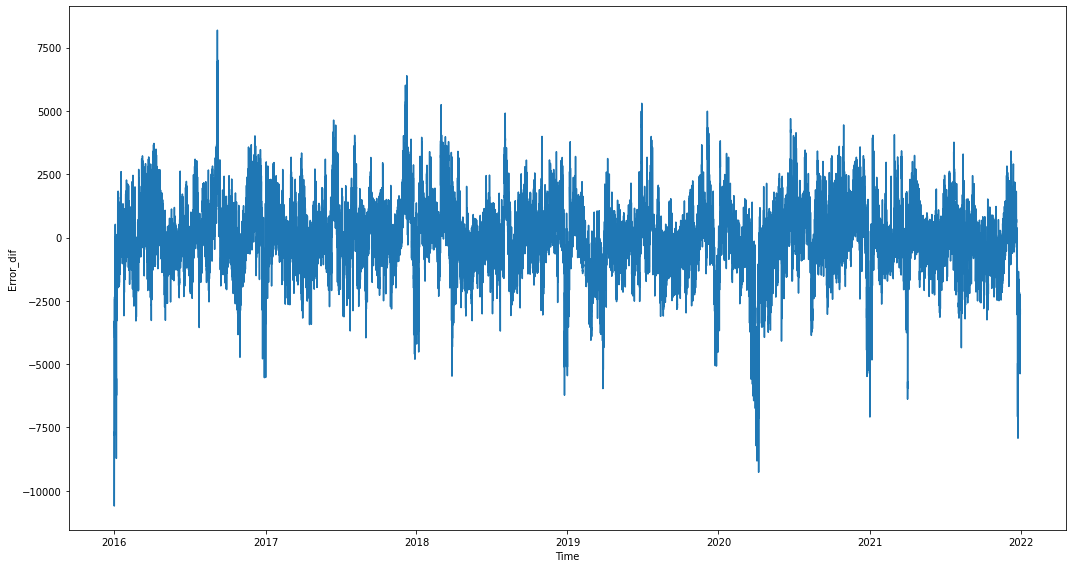

In [78]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot( x='Time', y='Error_dif',  data=df_final_results, legend=False)
plt.tight_layout()
plt.show()

In [82]:
rmse_val = mean_squared_error(df_final_results['Demand_MWh'], df_final_results['Forecast'])**0.5
mae_val=mean_absolute_error(df_final_results['Demand_MWh'], df_final_results['Forecast'])
mae_normalized=mae_val/df_final_results['Demand_MWh'].mean()*100

In [83]:
print('rmse: ',rmse_val)
print('mae: ',mae_val)
print('mae normalized: ',mae_normalized, ' %')

rmse:  1347.4843821703835
mae:  994.5888213500208
mae normalized:  3.5087926864852967  %
